In [24]:
########################################
## import packages
########################################
%matplotlib inline
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,  Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


import gc
import seaborn as sns
from snownlp import SnowNLP
from collections import Counter
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score


import cPickle
import gensim
import math
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis


import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [25]:
########################################
## set directories and parameters
########################################
BASE_DIR = 'data/'
EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300.bin'
TRAIN_DATA_FILE = BASE_DIR + 'cor_train.csv'
TEST_DATA_FILE = BASE_DIR + 'cor_test.csv'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.02

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

# 开始计算 glove 特征

In [26]:
########################################
## process texts in datasets
########################################
print('Processing text dataset')

# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

Processing text dataset


In [27]:
########################################
## text to sequence numbers
########################################
train_1 = [] 
train_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        train_1.append(text_to_wordlist(values[3]))
        train_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in train.csv' % len(train_1))

test_1 = []
test_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_1.append(text_to_wordlist(values[1]))
        test_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print('Found %s texts in test.csv' % len(test_1))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_1 + train_2 + test_1 + test_2)

sequences_1 = tokenizer.texts_to_sequences(train_1)
sequences_2 = tokenizer.texts_to_sequences(train_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)


labels = np.array(labels)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)

Found 404290 texts in train.csv
Found 2345796 texts in test.csv
Found 120500 unique tokens


In [28]:
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', data_2.shape)
print('Shape of data tensor:', test_data_1.shape)
print('Shape of label tensor:', test_data_2.shape)
print('Shape of label tensor:', labels.shape)

np.savetxt("data/data_1.csv", data_1, delimiter=",")
np.savetxt("data/data_2.csv", data_2, delimiter=",")
np.savetxt("data/test_data_1.csv", test_data_1, delimiter=",")
np.savetxt("data/test_data_2.csv", test_data_2, delimiter=",")
np.savetxt("data/labels.csv", labels, delimiter=",")

print 'finish'


('Shape of data tensor:', (404290, 30))
('Shape of label tensor:', (404290, 30))
('Shape of data tensor:', (2345796, 30))
('Shape of label tensor:', (2345796, 30))
('Shape of label tensor:', (404290,))
finish


In [29]:
########################################
## index word vectors
########################################
print('Indexing word vectors')

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, \
        binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Indexing word vectors
Found 3000000 word vectors of word2vec


In [30]:
########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

np.save('data/embedding_matrix.npy',embedding_matrix)

Preparing embedding matrix
Null word embeddings: 61789


In [31]:
data_1 = np.loadtxt("data/data_1.csv", delimiter=",")
data_2 = np.loadtxt("data/data_2.csv", delimiter=",")
test_data_1 = np.loadtxt("data/test_data_1.csv", delimiter=",")
test_data_2 = np.loadtxt("data/test_data_2.csv", delimiter=",")
labels = np.loadtxt("data/labels.csv", delimiter=",")
embedding_matrix = np.load('data/embedding_matrix.npy')
nb_words = 120501

# 开始计算传统特征

In [ ]:
########################################
## traditional features processing
########################################

train=pd.read_csv(TRAIN_DATA_FILE)
test=pd.read_csv(TEST_DATA_FILE)

train_qs=pd.Series(train['question1'].tolist()+
                   train['question2'].tolist()).astype(str)

test_qs=pd.Series(test['question1'].tolist()+
                  test['question2'].tolist()).astype(str)

stops=set(stopwords.words("english"))

In [ ]:
########################################
## traditional features function
########################################

#计算两句话的共有词
def word_match_share(row):
    q1words={}
    q2words={}
    for word in str(row['question1']).lower().split():
        if word not in stops:#如果不是stopwords则存入q1words=>(key,value)
            q1words[word]=1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word]=1
    if len(q1words)==0 or len(q2words)==0:
        return 0
    shared_words_q1=[w for w in q1words.keys() if w in q2words]
    shared_words_q2=[w for w in q2words.keys() if w in q1words]
    R=(len(shared_words_q1)+len(shared_words_q2)+0.0)/(len(q1words)+len(q2words))
    return R

def get_weight(count,eps=10000,min_count=2):
    if count<min_count:
        return 0
    else:
        return 1.0/(count+eps)
    
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + \
                    [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
        
    R = (np.sum(shared_weights)+0.0) / np.sum(total_weights)
    return R

def sentence_sentiment_diff(row):
    s1=SnowNLP(str(row['question1'])).sentiments
    s2=SnowNLP(str(row['question2'])).sentiments
    return (s1-s2)*(s1-s2)

words=(" ".join(train_qs)).lower().split()
counts=Counter(words)
weights={word:get_weight(count) for word,count in counts.items()}

# 如果已经保存特征，那么下面就不用执行了

In [ ]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()

x_train['word_match'] = train.apply(word_match_share,axis=1,raw=True)
x_test['word_match'] = test.apply(word_match_share, axis=1, raw=True)
x_train['tfidf_word_match'] = train.apply(tfidf_word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = test.apply(tfidf_word_match_share,axis=1,raw=True)
x_train['sentiment']=train.apply(sentence_sentiment_diff,axis=1,raw=True)
x_test['sentiment']=test.apply(sentence_sentiment_diff,axis=1,raw=True)

len_q1=train.question1.apply(lambda x: len(str(x)))
len_q2=train.question2.apply(lambda x: len(str(x)))
x_train['diff_len'] = abs(len_q1-len_q2)

len_char_q1=train.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
len_char_q2=train.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
x_train['diff_len_char']=abs(len_char_q1-len_char_q2)

len_word_q1=train.question1.apply(lambda x: len(str(x).split()))
len_word_q2=train.question2.apply(lambda x: len(str(x).split()))
x_train['diff_len_word']=abs(len_word_q1-len_word_q2)

len_q1=test.question1.apply(lambda x: len(str(x)))
len_q2=test.question2.apply(lambda x: len(str(x)))
x_test['diff_len'] = abs(len_q1-len_q2)

len_char_q1=test.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
len_char_q2=test.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
x_test['diff_len_char']=abs(len_char_q1-len_char_q2)

len_word_q1=test.question1.apply(lambda x: len(str(x).split()))
len_word_q2=test.question2.apply(lambda x: len(str(x).split()))
x_test['diff_len_word']=abs(len_word_q1-len_word_q2)

In [ ]:
df1 = train[['question1']].copy()
df2 = train[['question2']].copy()
df1_test = test[['question1']].copy()
df2_test = test[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)

print 'origin train_questions length:'

print len(train_questions)

#drop duplicated questions in train_questions
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

print 'after remove duplicates length:'

print len(train_questions)

#reset index of train_questions
train_questions.reset_index(inplace=True,drop=True)

#construct new Series (index,question)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()

train_cp = train.copy()
test_cp = test.copy()

train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)

comb = pd.concat([train_cp,test_cp])


comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

x_train['q1_freq']=train_comb['q1_freq']
x_train['q2_freq']=train_comb['q2_freq']

x_test['q1_freq']=test_comb['q1_freq']
x_test['q2_freq']=test_comb['q2_freq']

In [ ]:
x_train.to_pickle('data/x_train.pkl')
x_test.to_pickle('data/x_test.pkl')

# 直接调用保存好的 feature

In [ ]:
train_hand_features = pd.read_pickle('data/x_train.pkl')
test_hand_features = pd.read_pickle('data/x_test.pkl')
x_train = train_hand_features[['word_match','tfidf_word_match','sentiment','diff_len','diff_len_char','diff_len_word','q1_freq','q2_freq']]
x_test = test_hand_features[['word_match','tfidf_word_match','sentiment','diff_len','diff_len_char','diff_len_word','q1_freq','q2_freq']]

In [ ]:
# 新特征：句子关联句子
interdict_train=pd.read_csv('interdict_train.csv',index_col=0)
interdict_test=pd.read_csv('interdict_test.csv',index_col=0)

In [ ]:
# 新特征：各种句子之间的距离
dis_train=pd.read_csv('data/trainset_dis.csv')
dis_test=pd.read_csv('data/testset_dis.csv')
fuzz_train=pd.read_csv('data/fuzz_train.csv')
fuzz_test=pd.read_csv('data/fuzz_test.csv')
x_train = pd.concat([x_train, dis_train, fuzz_train, interdict_train], axis=1)
x_test = pd.concat([x_test, dis_test, fuzz_test, interdict_test], axis=1)

In [ ]:
print x_train.shape, x_test.shape, dis_train.shape, dis_test.shape

In [ ]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

data_columns = x_train.columns
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

ss = StandardScaler()
ss.fit(np.vstack((x_train, x_test)))
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

x_train = pd.DataFrame(data=x_train, columns=data_columns)
x_test = pd.DataFrame(data=x_test, columns=data_columns)

x_train.to_pickle('data/x_train_norm.pkl')
x_test.to_pickle('data/x_test_norm.pkl')

In [32]:
x_train = pd.read_pickle('data/x_train_norm.pkl')
x_test = pd.read_pickle('data/x_test_norm.pkl')

In [33]:
########################################
## sample train/validation data
########################################

np.random.seed(1234)
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))

data_3_train = np.vstack((x_train.values[idx_train],x_train.values[idx_train]))
data_3_val = np.vstack((x_train.values[idx_val],x_train.values[idx_val]))

labels_train = np.concatenate((labels[idx_train], labels[idx_train]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))


weight_val = np.ones(len(labels_val))

if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344
    class_weight = {0: 1.309028344, 1: 0.472001959}
    

In [34]:
num_lstm = 225
num_dense = 140
rate_drop_lstm = 0.37
rate_drop_dense = 0.16

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

In [35]:
########################################
## define the model structure
########################################
os.environ["CUDA_VISIBLE_DEVICES"]="4"

embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer =  Bidirectional(LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

z1 = Input(shape=(x_train.shape[1],), dtype='float32')
z1_dense = Dense(num_dense/2, activation=act)(z1)

merged = concatenate([x1, y1, z1_dense])
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [36]:
########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input, z1], \
        outputs=preds)
# model.load_weights(bst_model_path)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
#model.summary()
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_loss',save_best_only=True, save_weights_only=True)
# model.load_weights(bst_model_path)
hist = model.fit([data_1_train, data_2_train, data_3_train], labels_train, \
        validation_data=([data_1_val, data_2_val, data_3_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])


lstm_225_140_0.37_0.16
Train on 792408 samples, validate on 16172 samples
Epoch 1/200
792408/792408 [==============================] - 218s - loss: 0.2366 - acc: 0.8294 - val_loss: 0.2041 - val_acc: 0.8454
Epoch 2/200
792408/792408 [==============================] - 217s - loss: 0.1949 - acc: 0.8562 - val_loss: 0.1935 - val_acc: 0.8679
Epoch 3/200
792408/792408 [==============================] - 218s - loss: 0.1849 - acc: 0.8639 - val_loss: 0.1838 - val_acc: 0.8611
Epoch 4/200
792408/792408 [==============================] - 219s - loss: 0.1767 - acc: 0.8711 - val_loss: 0.1822 - val_acc: 0.8668
Epoch 5/200
792408/792408 [==============================] - 219s - loss: 0.1703 - acc: 0.8759 - val_loss: 0.1790 - val_acc: 0.8770
Epoch 6/200
792408/792408 [==============================] - 219s - loss: 0.1644 - acc: 0.8806 - val_loss: 0.1740 - val_acc: 0.8681
Epoch 7/200
792408/792408 [==============================] - 219s - loss: 0.1597 - acc: 0.8845 - val_loss: 0.1712 - val_acc: 0.8816
Ep

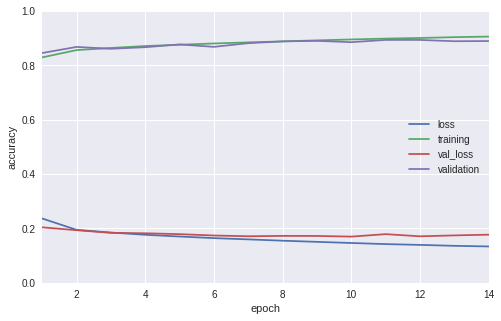

In [37]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in hist.epoch ],
                    'training': hist.history['acc'],
                    'validation': hist.history['val_acc'],
                    'loss': hist.history['loss'],
                   'val_loss': hist.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [38]:
bst_val_score = min(hist.history['val_loss'])

########################################
## make the submission
########################################
model.load_weights(bst_model_path)

preds = model.predict([test_data_1, test_data_2, x_test.values], batch_size=5000, verbose=1)
preds += model.predict([test_data_2, test_data_1, x_test.values], batch_size=5000, verbose=1)
preds /= 2


2345796/2345796 [==============================] - 223s   


In [43]:
text_ids = np.arange(len(preds))
submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)

In [7]:
a = 'helloworld'
print len(set(a))

7
